## Data Exploration 

In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy 

**Reminder**: 
- each day, the customer IDs start again at 1. These are different customers anyway.
- when the shop closes, the remaining customers are rushed through the checkout. Their checkout is not recorded, so it may look as if they stay in the market forever.

### Load the Files 

In [2]:
csv_files = os.listdir("/home/michaelhaag/Documents/Coding/Spiced_Code/Code-Repository/Week_08/Data")
csv_files

['tuesday.csv', 'thursday.csv', 'friday.csv', 'wednesday.csv', 'monday.csv']

In [3]:
dfs = {}
for file in csv_files: 
    dfs[file.split(".")[0]] = pd.read_csv(f"../Data/{file}", sep=";", parse_dates=["timestamp"])

Some cleaning is necessary: 

## Exploration 

Let's start with just one day: **tuesday** 

### Get the "metadata"

In [5]:
df_tuesday = dfs["tuesday"]

In [6]:
df_tuesday.shape

(4714, 3)

In [7]:
df_tuesday.columns

Index(['timestamp', 'customer_no', 'location'], dtype='object')

In [8]:
df_tuesday.head()

,timestamp,customer_no,location
0,2019-09-03 07:02:00,1,fruit
1,2019-09-03 07:02:00,2,drinks
2,2019-09-03 07:03:00,3,dairy
3,2019-09-03 07:05:00,1,drinks
4,2019-09-03 07:06:00,4,dairy


In [9]:
df_tuesday.tail()

,timestamp,customer_no,location
4709,2019-09-03 21:47:00,1421,drinks
4710,2019-09-03 21:47:00,1422,dairy
4711,2019-09-03 21:48:00,1421,checkout
4712,2019-09-03 21:49:00,1412,checkout
4713,2019-09-03 21:50:00,1411,dairy


In [10]:
df_tuesday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4714 entries, 0 to 4713
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    4714 non-null   datetime64[ns]
 1   customer_no  4714 non-null   int64         
 2   location     4714 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 110.6+ KB


### The actual exploration 

**Note**: I'll only do the exploration for tuesday and I'll be assuming that the other days are roughly equal 

**Task 1**: Calculate the total number of customers in each section

<AxesSubplot:xlabel='location'>

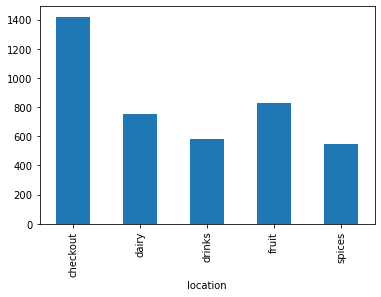

In [11]:
df_tuesday.groupby("location")["customer_no"].nunique().plot(kind="bar") 

**Task 2**: Calculate the total number of customers in each section over time **and**  
**Task 3**: Display the number of customers at checkout over time (last plot) 



Let's start with the dairy location (to get a feel) 

In [12]:
filt = (df_tuesday["location"] == "dairy")
df = df_tuesday[filt].set_index("timestamp")
df.head(3)

,customer_no,location
timestamp,,
2019-09-03 07:03:00,3,dairy
2019-09-03 07:06:00,4,dairy
2019-09-03 07:06:00,5,dairy


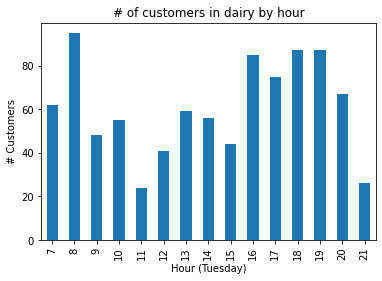

In [13]:
ax = df.resample("h")["customer_no"].count().plot(title="# of customers in dairy by hour",
                                                  kind="bar",
                                                  xlabel="Hour (Tuesday)", ylabel="# Customers");
ax.set_xticklabels(set(df.index.hour));

Let's do it for **all** locations

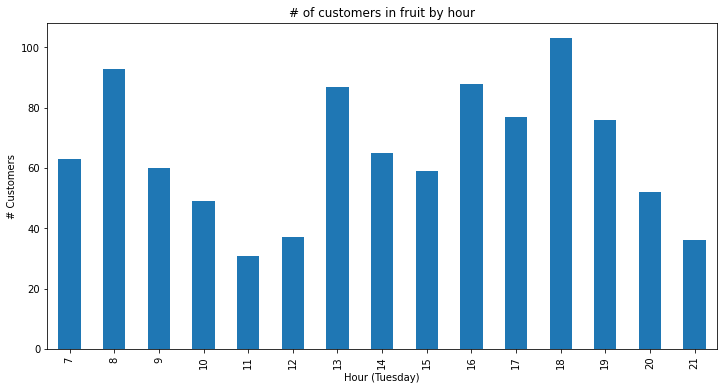

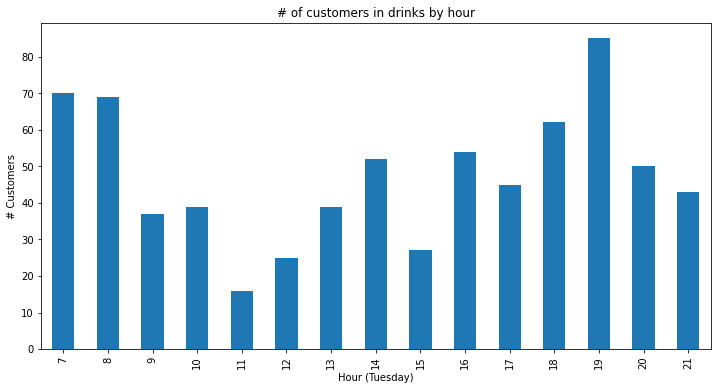

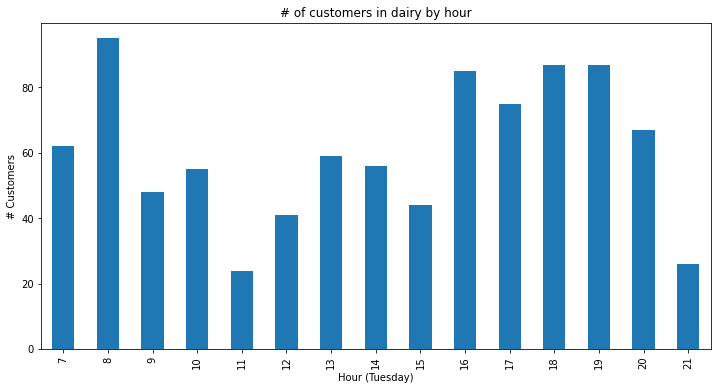

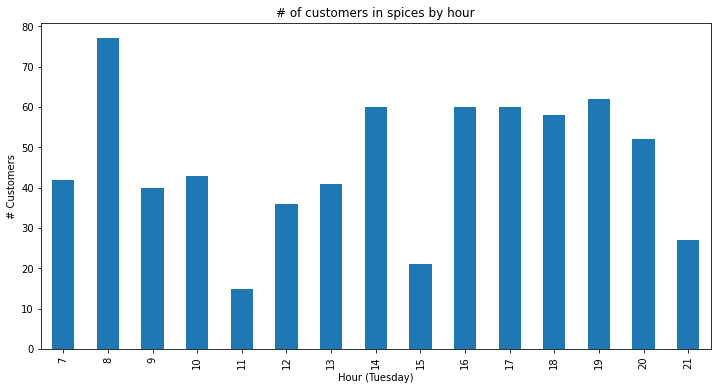

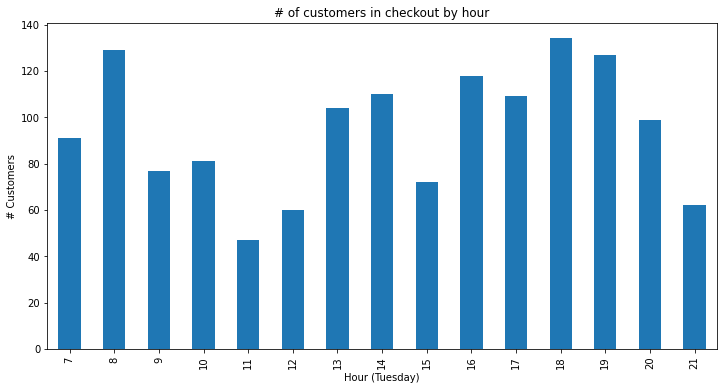

In [13]:
locations = list(df_tuesday["location"].unique())

for location in locations: 
    #Filtering and setting the index to the timestamp! 
    filt = (df_tuesday["location"] == location)
    df = df_tuesday[filt].set_index("timestamp") 
    #Plotting
    plt.figure(figsize=(12,6))
    ax = df.resample("h")["customer_no"].count().plot(title=f"# of customers in {location} by hour",
                                                  kind="bar",
                                                  xlabel="Hour (Tuesday)", ylabel="# Customers");
    ax.set_xticklabels(set(df.index.hour));
    plt.show()

Some **binning** 

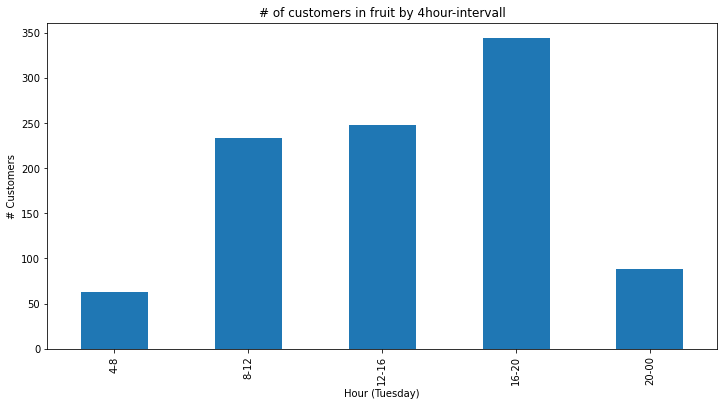

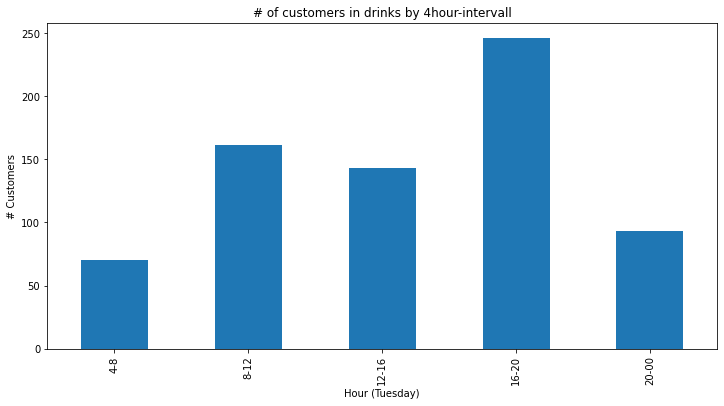

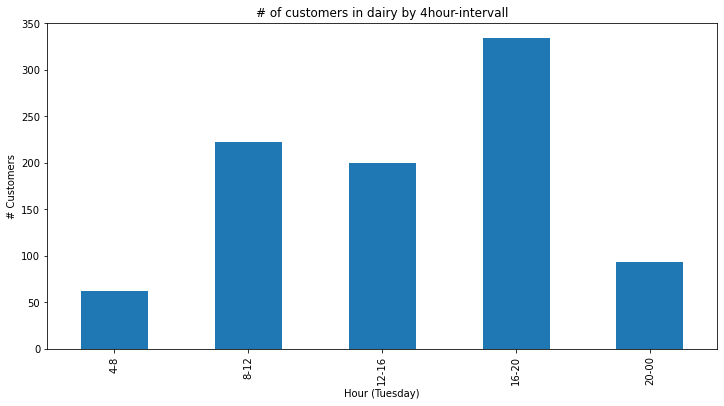

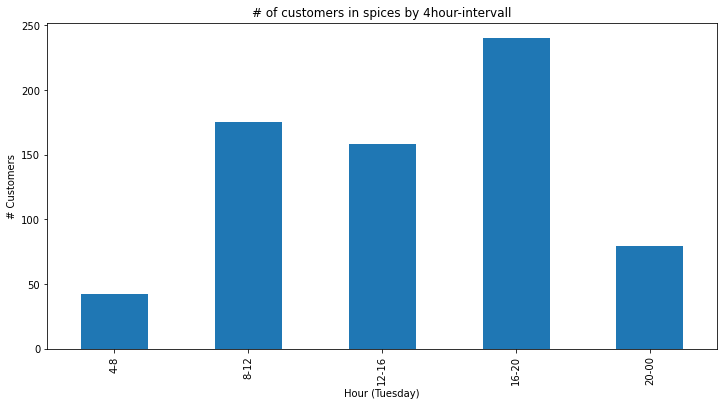

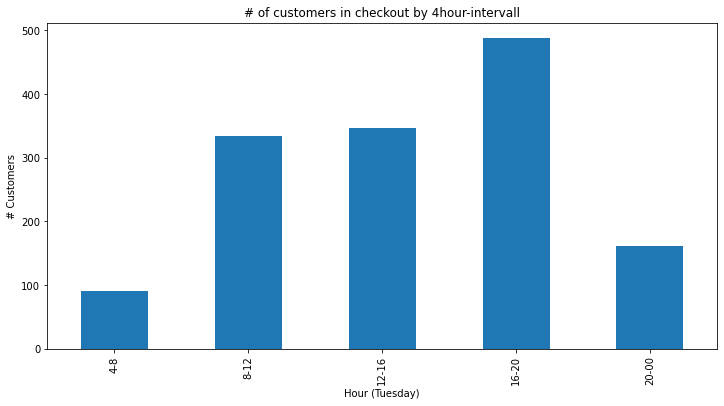

In [14]:
locations = list(df_tuesday["location"].unique())

for location in locations: 
    #Filtering and resampling
    filt = (df_tuesday["location"] == location)
    df = df_tuesday[filt].set_index("timestamp") 
    #Plotting
    plt.figure(figsize=(12,6))
    ax = df.resample("4h")["customer_no"].count().plot(title=f"# of customers in {location} by 4hour-intervall",
                                                  kind="bar",
                                                  xlabel="Hour (Tuesday)", ylabel="# Customers");
    ax.set_xticklabels(["4-8","8-12","12-16","16-20","20-00"]);
    plt.show()

**Task 4**: Calculate the time each customer spent in the market

The time a customer (for example: customer 1) has spent in the market is the difference in time between whatever location he visited in the beginning and his time at the checkout  

**NOTE**: when the shop closes, the remaining customers are rushed through the checkout. 
Their checkout is not recorded, so it may look as if they stay in the market forever.



In [15]:
df_tuesday.head()

,timestamp,customer_no,location
0,2019-09-03 07:02:00,1,fruit
1,2019-09-03 07:02:00,2,drinks
2,2019-09-03 07:03:00,3,dairy
3,2019-09-03 07:05:00,1,drinks
4,2019-09-03 07:06:00,4,dairy


In [16]:
len(df_tuesday)

4714

In [17]:
#Find all those customers without recorded checkout 
filt = (df_tuesday["location"] =="checkout")
regular_checkouts = df_tuesday[filt]["customer_no"].unique() ## All the customers who regularly checked out 
all_customers = df_tuesday["customer_no"]
rushed_customers = all_customers[~all_customers.isin(regular_checkouts)].unique()
print(rushed_customers)
for customer in rushed_customers:
    index = df_tuesday.loc[df_tuesday["customer_no"]==customer].index[-1]
    
    #Construct Date 
    day = df_tuesday.loc[index,"timestamp"].day
    month = df_tuesday.loc[index,"timestamp"].month
    year = df_tuesday.loc[index,"timestamp"].year
    #There must be an easier way :(, NOTE: This is dangerous due to the prefixed zero, e.g. if month = 12 then datestring -> 012, which will lead to an
    #error converting 
    date_string = f"0{day}:0{month}:{year}:22"
    print(date_string)
    date_timestamp = pd.to_datetime(date_string,format="%d:%m:%Y:%H")


# This did not lead anywhere, I just gave up :( 

[1411 1422]
03:09:2019:22
03:09:2019:22


I had enough, let's simply **drop** all the rushed customers! 

In [18]:
filt = (df_tuesday["location"] =="checkout")
regular_checkouts = df_tuesday[filt]["customer_no"].unique() ## All the customers who regularly checked out 
all_customers = df_tuesday["customer_no"]
rushed_customers = all_customers[~all_customers.isin(regular_checkouts)].unique()
print(rushed_customers)

for customer in rushed_customers: 
    filt = (df_tuesday["customer_no"]==customer)
    df_tuesday.drop(df_tuesday[filt].index,inplace=True) 
len(df_tuesday)

[1411 1422]


4705

Now let's finally tackle **task 4**: 

In [19]:
groups = df_tuesday.groupby("customer_no")["timestamp"]
groups.get_group(3)

2    2019-09-03 07:03:00
13   2019-09-03 07:10:00
Name: timestamp, dtype: datetime64[ns]

In [20]:
time_spent= df_tuesday.groupby("customer_no")["timestamp"].transform(lambda x: x.max()-x.min()) 
#Works exaktly like in the example

df_tuesday["time_spent_total"] = time_spent

In [21]:
df_tuesday.head(1)

,timestamp,customer_no,location,time_spent_total
0,2019-09-03 07:02:00,1,fruit,0 days 00:10:00


In [22]:
df_tuesday.loc[df_tuesday["customer_no"]==10]

time_spent_unique = df_tuesday.groupby("customer_no")["time_spent_total"].unique()
time_spent_minutes = (time_spent_unique/60_000_000_000).astype(int) #Somehow it is in nanoseconds, convert to int to plot 

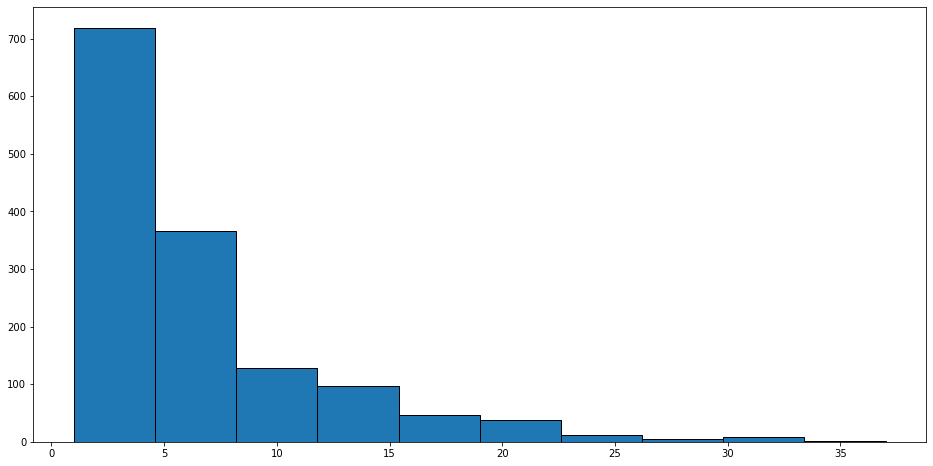

In [23]:
plt.figure(figsize=(16,8));
plt.hist(time_spent_minutes,edgecolor='black');

**Task 5**: Calculate the total number of customers in the supermarket over time.

In [24]:
df_tuesday.set_index("timestamp",inplace=True)
df_tuesday.drop("time_spent_total",axis=1)

,customer_no,location
timestamp,,
2019-09-03 07:02:00,1,fruit
2019-09-03 07:02:00,2,drinks
2019-09-03 07:03:00,3,dairy
2019-09-03 07:05:00,1,drinks
2019-09-03 07:06:00,4,dairy
...,...,...
2019-09-03 21:46:00,1420,checkout
2019-09-03 21:46:00,1421,fruit
2019-09-03 21:47:00,1421,drinks


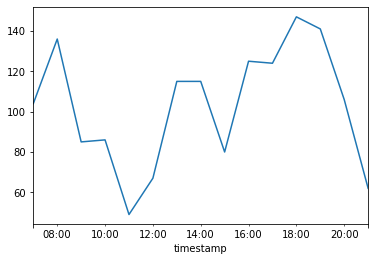

In [25]:
df_tuesday.resample("h")["customer_no"].nunique().plot();

**Task 6**: Our business managers think that the **first section customers visit follows a different pattern than the following ones**. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

I am not sure wether the following code actually answers the questions, but I tried my best

In [26]:
#Reload the tuesday 
#df_tuesday.drop("time_spent_total",axis=1,inplace=True)
df_tuesday["timestamp"] = df_tuesday.index
df_tuesday.head()

,customer_no,location,time_spent_total,timestamp
timestamp,,,,
2019-09-03 07:02:00,1,fruit,0 days 00:10:00,2019-09-03 07:02:00
2019-09-03 07:02:00,2,drinks,0 days 00:15:00,2019-09-03 07:02:00
2019-09-03 07:03:00,3,dairy,0 days 00:07:00,2019-09-03 07:03:00
2019-09-03 07:05:00,1,drinks,0 days 00:10:00,2019-09-03 07:05:00
2019-09-03 07:06:00,4,dairy,0 days 00:06:00,2019-09-03 07:06:00


In [27]:
groups = df_tuesday.groupby("customer_no")["location"]

I had to see what was going wrong 

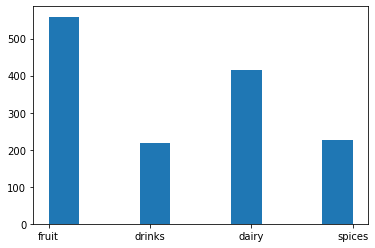

In [28]:
locations_first_visited = []
customers = df_tuesday["customer_no"].unique()
for customer in customers: 
    #print(f"customer:{customer}")
    #print(groups.get_group(customer))
    locations_first_visited.append(groups.get_group(customer)[0]) #Note: The ordering, the first entry is the first visit! 

plt.hist(locations_first_visited);

In [33]:
first_visits = pd.Series(locations_first_visited)

In [36]:
distr = first_visits.value_counts()

In [35]:
first_visits.value_counts().sum()

1420

In [47]:
distr/1420

fruit     0.393662
dairy     0.292958
spices    0.159155
drinks    0.154225
dtype: float64

In [29]:
following_sections=[]
counter=0
for customer in customers:
    #print(counter)
    following_sections.append(groups.get_group(customer)[1:-1].astype(str).values.tolist()) #skip the first one and "checkout" 
    #print(groups.get_group(customer))
    #counter+=1
    
lst = list(following_sections)



In [30]:
flat_list = []

In [31]:
for one_lst in lst: 
    for element in one_lst: 
            flat_list.append(element) #Somehow the nice list comprehension didn't work so I had to work with nested for-loops

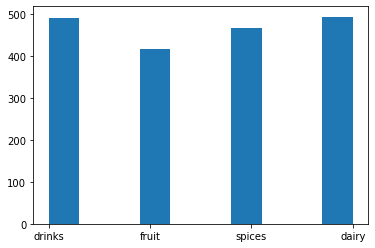

In [32]:
plt.hist(flat_list);

### Get some probabilites for customer visit given time (note that I only use tuesday, since I am a bit lazy today)

In [26]:
df_tuesday.info()
df_tuesday.set_index("timestamp",inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4714 entries, 0 to 4713
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    4714 non-null   datetime64[ns]
 1   customer_no  4714 non-null   int64         
 2   location     4714 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 110.6+ KB


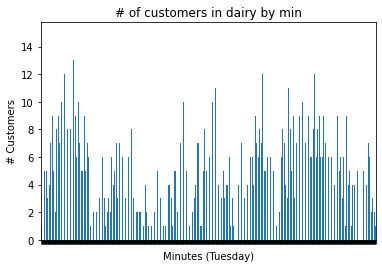

In [27]:
ax = df_tuesday.resample("1min")["customer_no"].nunique().plot(title="# of customers in dairy by min",
                                                  kind="bar",
                                                  xlabel="Minutes (Tuesday)", ylabel="# Customers");
ax.set_xticklabels(labels=[]);

In [58]:
df = pd.DataFrame(df_tuesday.resample("1min")["customer_no"].nunique())
df.rename(columns={"customer_no":"count"},inplace=True)

In [59]:
type(df)

pandas.core.frame.DataFrame

In [60]:
df.head()

,count
timestamp,
2019-09-03 07:02:00,2
2019-09-03 07:03:00,1
2019-09-03 07:04:00,0
2019-09-03 07:05:00,1
2019-09-03 07:06:00,2


In [61]:
customers_total = df["count"].sum()
customers_total
df["probab"] = df["count"].div(customers_total)

In [62]:
df.head()

,count,probab
timestamp,,
2019-09-03 07:02:00,2,0.000424
2019-09-03 07:03:00,1,0.000212
2019-09-03 07:04:00,0,0.000000
2019-09-03 07:05:00,1,0.000212
2019-09-03 07:06:00,2,0.000424


In [63]:
df["probab"].sum()

1.0

In [68]:
thirty_min_steps_prob = df.resample("30min")["probab"].sum()

<AxesSubplot:xlabel='timestamp'>

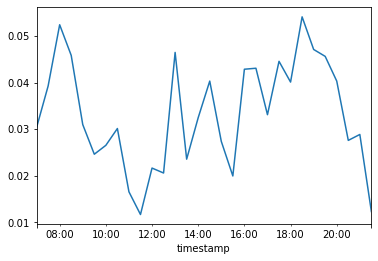

In [71]:
df.resample("30min")["probab"].sum().plot()

In [74]:
thirty_min_steps_prob.head()

timestamp
2019-09-03 07:00:00    0.030335
2019-09-03 07:30:00    0.039245
2019-09-03 08:00:00    0.052397
2019-09-03 08:30:00    0.045821
2019-09-03 09:00:00    0.030972
Freq: 30T, Name: probab, dtype: float64

In [72]:
thirty_min_steps_prob.sum()

1.0

In [78]:
df_resampled = df.resample("30min")["probab","count"].sum()

In [80]:
df_resampled.head()

,probab,count
timestamp,,
2019-09-03 07:00:00,0.030335,143
2019-09-03 07:30:00,0.039245,185
2019-09-03 08:00:00,0.052397,247
2019-09-03 08:30:00,0.045821,216
2019-09-03 09:00:00,0.030972,146


In [85]:
df_resampled.to_csv("event_probab.csv")

In [73]:
import random as rd

In [84]:
visits = []
customer_no = 100
for i in range(0,customer_no):
    visits.append(rd.choices(df_resampled.index,df_resampled["probab"]))
visits

[[Timestamp('2019-09-03 21:30:00', freq='30T')],
 [Timestamp('2019-09-03 16:30:00', freq='30T')],
 [Timestamp('2019-09-03 21:00:00', freq='30T')],
 [Timestamp('2019-09-03 09:30:00', freq='30T')],
 [Timestamp('2019-09-03 07:30:00', freq='30T')],
 [Timestamp('2019-09-03 13:30:00', freq='30T')],
 [Timestamp('2019-09-03 14:30:00', freq='30T')],
 [Timestamp('2019-09-03 14:00:00', freq='30T')],
 [Timestamp('2019-09-03 21:00:00', freq='30T')],
 [Timestamp('2019-09-03 21:00:00', freq='30T')],
 [Timestamp('2019-09-03 15:00:00', freq='30T')],
 [Timestamp('2019-09-03 08:00:00', freq='30T')],
 [Timestamp('2019-09-03 07:00:00', freq='30T')],
 [Timestamp('2019-09-03 18:30:00', freq='30T')],
 [Timestamp('2019-09-03 13:30:00', freq='30T')],
 [Timestamp('2019-09-03 08:00:00', freq='30T')],
 [Timestamp('2019-09-03 20:00:00', freq='30T')],
 [Timestamp('2019-09-03 17:00:00', freq='30T')],
 [Timestamp('2019-09-03 18:00:00', freq='30T')],
 [Timestamp('2019-09-03 21:00:00', freq='30T')],
 [Timestamp('2019-09

In [82]:
visits

[Timestamp('2019-09-03 16:00:00', freq='30T')]